In [75]:
from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
import multiprocessing as mp
import os
import re
import numpy as np
import xarray as xr

from calibration import parse_ids
from karabo_data import DataCollection, by_index, RunDirectory


# Evaluate dark offset

In [76]:
def dark_offset(module_number, path, *, pulse_ids=None):
    """ Process Dark data

    Parameters
    ----------
    module_number: int
        Channel number between 0, 15
    path: str
        Path to Run folder
    pulse_ids: str
        For eg. ":" to select all pulses in a train
                "start:stop:step" to select indices with certain step size
                "1,2,3" comma separated pulse index to select specific pulses
                "1,2,3, 5:10" mix of above two
        Default: all pulses ":"
        
    Return
    ------
    out: ndarray
        Shape: (n_pulses, ..., slow_scan, fast_scan)
    """

    if not path or module_number not in range(16):
        return

    pattern = f"(.+)LPD{module_number:02d}(.+)"

    files = [os.path.join(path, f) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)]

    if not files:
        return

    run = DataCollection.from_paths(files)

    module = [key for key in run.instrument_sources
              if re.match(r"(.+)/DET/(.+):(.+)", key)]

    if len(module) != 1:
        return
    
    run = run.select([(module[0], "image.data")])
    
    pulse_ids = ":" if pulse_ids is None else pulse_ids
    pulses = parse_ids(pulse_ids)
    
    mean_image = 0
    counts = 0
    for tid, data in run.trains(devices=[(module[0], "image.data")], require_all=True):
        image = np.squeeze(data[module[0]]["image.data"], axis=1) # (pulses, 1, ss, fs)
        
        if pulses != [-1]:
            image = image[pulses, ...].astype(np.float32)
        else:
            image = image.astype(np.float32)
        
        mean_image += image
        counts += 1
     
    return mean_image / counts


In [77]:
modules = "0:16"
pulse_ids = ":"
dark_folder = "path"

module_numbers = parse_ids(modules)
print(module_numbers)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
_dark_eval = partial(dark_offset, 
                     path=dark_folder, 
                     pulse_ids=pulse_ids)

dark_data = {}
with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data[modno] = ret
       

# Write dark offset to file

In [ ]:
dark_data_file = "path"

with h5py.File(dark_data, "w") as f:
    for modno, data in dark_data.items():
        g = f.create_group(f"entry_1/instrument/module_{modno}")
        g.create_dataset('data', data=data)


# Delay scan

In [8]:
def roi_intensity(module_number, path, *, pulse_ids=None, rois=None):
    
    if not path or module_number not in range(16):
        return

    pattern = f"(.+)LPD{module_number:02d}(.+)"

    files = [os.path.join(path, f) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)]

    if not files:
        return

    run = DataCollection.from_paths(files)

    module = [key for key in run.instrument_sources
              if re.match(r"(.+)/DET/(.+):(.+)", key)]

    if len(module) != 1:
        return
    
    run = run.select([(module[0], "image.data")])
    
    pulse_ids = ":" if pulse_ids is None else pulse_ids
    pulses = parse_ids(pulse_ids)
    
    intensities = []
    train_ids = []
    for tid, data in run.trains(devices=[(module[0], "image.data")], require_all=True):
        image = np.squeeze(data[module[0]]["image.data"], axis=1) # (pulses, 1, ss, fs)
        
        if rois is not None:
            x0, x1, y0, y1 = rois
            image = image[..., x0:x1, y0:y1]
        
        if pulses != [-1]:
            image = image[pulses, ...].astype(np.float32)
        else:
            image = image.astype(np.float32)
        
        intensities.append(np.mean(image, axis=(-1,-2)))
        train_ids.append(tid)
    
    coords = {'trainId':np.array(train_ids)}
    dims = ['trainId', 'dim_0']
    data = xr.DataArray(np.stack(intensities), dims=dims, coords=coords)
    
    return data

In [85]:
modules = "14, 15"
pulse_ids = ":"
run_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0004"

rois = [0, 256, 0, 256]

module_numbers = parse_ids(modules)
print(module_numbers)

[14, 15]


In [86]:
_roi_intensity_eval = partial(roi_intensity, 
                              path=run_folder, 
                              pulse_ids=pulse_ids,
                              rois=rois)

roi_intensities = {}
with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(
        module_numbers, executor.map(_roi_intensity_eval, module_numbers)):
        roi_intensities[modno] = ret
       

In [87]:
roi_intensities[15]

<xarray.DataArray (trainId: 502, dim_0: 510)>
array([[1117.4146, 1111.7777, 1092.2872, ..., 1113.516 , 1110.8552, 1112.3639],
       [1160.6366, 1142.1505, 1119.0603, ..., 1137.5325, 1134.034 , 1135.5115],
       [1158.7926, 1141.2252, 1119.424 , ..., 1136.9497, 1134.3665, 1134.9023],
       ...,
       [1159.375 , 1142.454 , 1119.854 , ..., 1138.0104, 1134.6367, 1136.1415],
       [1160.4048, 1143.5243, 1119.7999, ..., 1137.5447, 1133.4465, 1135.8755],
       [1159.0317, 1141.9644, 1120.9702, ..., 1137.0004, 1134.1418, 1135.6324]],
      dtype=float32)
Coordinates:
  * trainId  (trainId) int64 545502939 545502940 ... 545503439 545503440
Dimensions without coordinates: dim_0

# Get Delay arrays

In [124]:
delay_src = "SA1_XTD2_XGM/DOOCS/MAIN"
delay_prop = "pulseEnergy.photonFlux.value"

run = RunDirectory(run_folder)

# get delay data: xarray
delay_data = run.get_array(delay_src, delay_prop)

delay_data = delay_data.expand_dims('dim_1', axis=1)
print(delay_data)

<xarray.DataArray (trainId: 553, dim_1: 1)>
array([[1034.1405],
       [1034.1405],
       [1034.1405],
       ...,
       [1027.48  ],
       [1027.48  ],
       [1027.48  ]], dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 545502932 545502933 ... 545503483 545503484
Dimensions without coordinates: dim_1


## Align delay data with ROI Intesities along TrainIds and plot


<IPython.core.display.Javascript object>


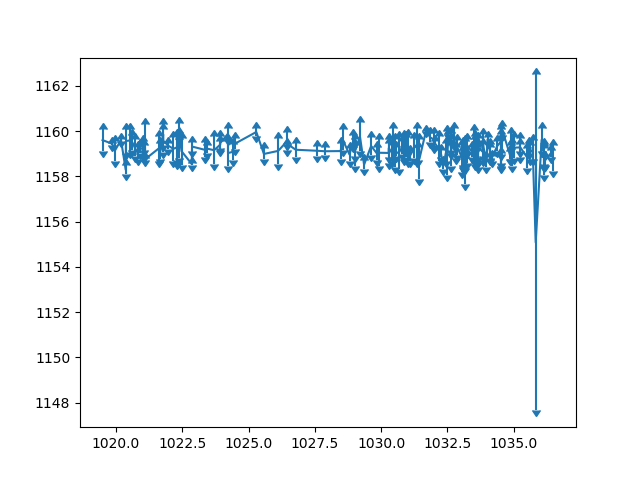

<IPython.core.display.Javascript object>


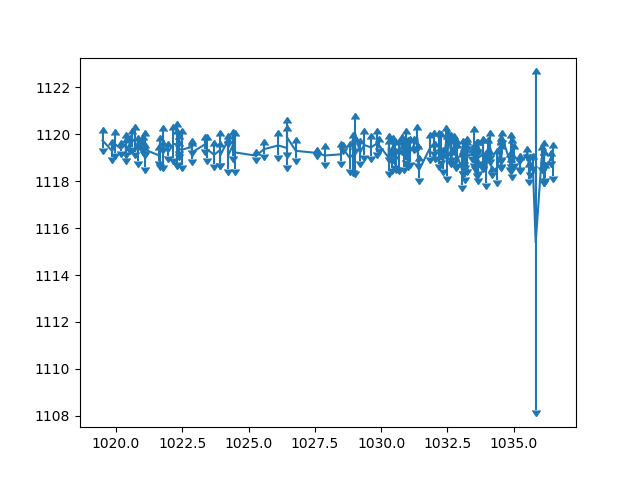

In [149]:
import  matplotlib.pyplot as plt
%matplotlib notebook

pulse = 15

for modno in module_numbers:
    roi_int, delay = xr.align(roi_intensities[modno], delay_data)
    
    s = list(zip(delay[:, 0].values, roi_int[:, pulse].values))
    roi_int_avg = []
    roi_int_std = []
    delay = []
    for key, group in groupby(sorted(s), lambda x: x[0]):
        x, y = zip(*group)
        avg, std = np.mean(np.array(y)), np.std(np.array(y))
        roi_int_avg.append(avg)
        roi_int_std.append(std)
        delay.append(x[0])        
    
    fig, ax = plt.subplots(1, 1)
    ax.errorbar(delay, roi_int_avg, yerr=roi_int_std, uplims=True, lolims=True,)
    


In [83]:
r = RunDirectory("/gpfs/exfel/exp/FXE/201931/p900089/raw/r0004")

In [84]:
r.info()

# of trains:    553
Duration:       0:00:55.200000
First train ID: 545502932
Last train ID:  545503484

15 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 1 : 256 x 256 pixels
  FXE_DET_LPD1M-1/DET/1CH0:xtdf
  510 frames per train, up to 282030 frames total

3 instrument sources (excluding detectors):
  - FXE_SMS_MOV/SMSXEY/CAMERA:daqOutput
  - SA1_XTD2_XGM/DOOCS/MAIN:output
  - SPB_XTD9_XGM/DOOCS/MAIN:output

6 control sources:
  - FXE_AUXT_LIC/DOOCS/PPLASER
  - FXE_AUXT_LIC/DOOCS/PPODL
  - FXE_AUXT_LIC/DOOCS/TANGERINE
  - FXE_SMS_MOV/SMSXEY/CAMERA
  - SA1_XTD2_XGM/DOOCS/MAIN
  - SPB_XTD9_XGM/DOOCS/MAIN



In [93]:
r.keys_for_source("SA1_XTD2_XGM/DOOCS/MAIN")
r.get_array("SA1_XTD2_XGM/DOOCS/MAIN", 'pulseEnergy.photonFlux.value')
# dc = r.get_data_counts("FXE_DET_LPD1M-1/DET/12CH0:xtdf", "image.data")
# dc[dc != 0]


<xarray.DataArray (trainId: 553)>
array([1034.1405, 1034.1405, 1034.1405, ..., 1027.48  , 1027.48  , 1027.48  ],
      dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 545502932 545502933 ... 545503483 545503484

In [111]:
from itertools import groupby

a = [1, 2, 3,4, 5, 6, 7, 8, 9, 10]
b = [np.random.rand(4) for i in range(len(a))]  
c = np.stack(b)

x = xr.DataArray(c, dims=['trainids', 'dim1'], coords={'trainids':np.array(a)})  

d = [1, 2, 3,4, 5, 6, 7, 8]
y = xr.DataArray(np.random.rand(8,1), dims=['trainids', 'dim2'], coords={'trainids':np.array(d)})

al1, al2 = xr.align(x, y)
print(x)
print(y)

<xarray.DataArray (trainids: 10, dim1: 4)>
array([[0.933429, 0.23784 , 0.460134, 0.332784],
       [0.371345, 0.437111, 0.319217, 0.604577],
       [0.841307, 0.412523, 0.638722, 0.983509],
       [0.786425, 0.27099 , 0.269052, 0.033219],
       [0.812319, 0.164178, 0.218772, 0.582315],
       [0.732045, 0.869201, 0.636673, 0.266405],
       [0.356829, 0.860491, 0.644261, 0.751464],
       [0.681461, 0.403105, 0.596001, 0.700269],
       [0.469937, 0.424876, 0.474094, 0.584814],
       [0.348739, 0.53572 , 0.242064, 0.621331]])
Coordinates:
  * trainids  (trainids) int64 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: dim1
<xarray.DataArray (trainids: 8, dim2: 1)>
array([[0.252609],
       [0.615567],
       [0.993344],
       [0.759012],
       [0.778574],
       [0.563144],
       [0.747664],
       [0.573003]])
Coordinates:
  * trainids  (trainids) int64 1 2 3 4 5 6 7 8
Dimensions without coordinates: dim2


<IPython.core.display.Javascript object>


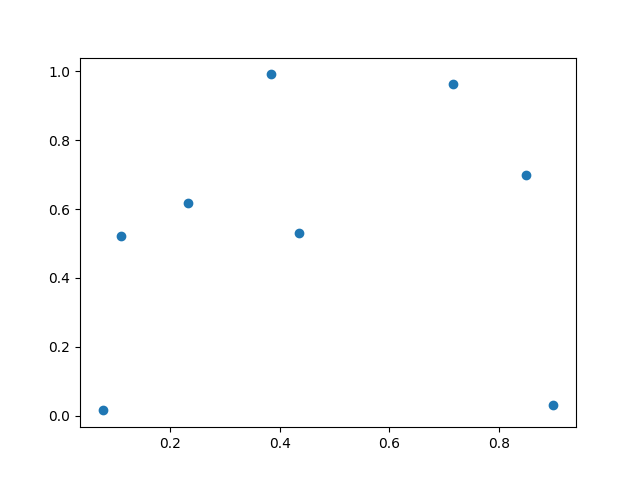

In [64]:
import  matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(al1[:, 0], al2[:], 'o')